# Strong (Dirichlet) boundary conditions

Let's move on from the Helmholtz problem to Poisson:

$$-\nabla^2u = f$$

for some known function $f$. To have a well-posed problem, we must impose Dirichlet conditions over at least part of the domain boundary:

$$u(x) = g(x) \quad \forall x \in \Gamma_D,\\
\nabla u(x)\cdot \vec{n} = h(x) \quad \forall x \in \Gamma_N.$$

As before, the Neumann condition is imposed weakly by setting the boundary integral over the relevant part of the boundary. The Dirichlet condition is imposed strongly by modifying the function space from which $u$ is drawn.

Suppose $V\ni u$ is a finite element space. Then we write:

$$V_D = \{u\in V \,|\,u(x) = g \quad \forall x \in \Gamma_D\},$$
$$V_0 = \{u\in V \,|\,u(x) = 0 \quad \forall x \in \Gamma_D\}.$$

The weak form of the problem then becomes, find $u\in V_D$ such that:

$$\int_\Omega \nabla u \cdot \nabla v\, \mathrm{d}x - \int_{\Gamma_N} hv\, \mathrm{d}s = \int_\Omega fv\mathrm{d}x \quad\forall v\in V_0.$$

In Firedrake, the weak form is always formulated in the unmodified space $V$. The modification to the function spaces implied by the Dirichlet conditions is then imposed by supplying a [`DirichletBC` object](http://firedrakeproject.org/firedrake.html#firedrake.bcs.DirichletBC) to the solve.

As usual, we start by setting up the notebook matplotlib interaction, and importing Firedrake.  We then choose a triangulation of our domain and select an appropriate $H^1$-conforming function space.

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
# Load Firedrake on Colab
try:
    import firedrake
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake
from firedrake import *
mesh = UnitSquareMesh(10, 10)
V = FunctionSpace(mesh, "Lagrange", 1)

--2022-05-27 15:31:35--  https://fem-on-colab.github.io/releases/firedrake-install-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.111.153, 185.199.109.153, 185.199.108.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.111.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3255 (3.2K) [application/x-sh]
Saving to: ‘/tmp/firedrake-install.sh’

/tmp/firedrake-inst 100%[===================>]   3.18K  --.-KB/s    in 0s      

2022-05-27 15:31:36 (49.6 MB/s) - ‘/tmp/firedrake-install.sh’ saved [3255/3255]

+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FIREDRAKE_INSTALLED=/usr/local/share/fem-on-colab/firedrake.installed
+ [[ ! -f /usr/local/share/fem-on-colab/firedrake.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/60fe1e0/releases/pybind11-install.sh
+ [[ https://github.com/fem-on-colab/fem-on-colab.github.io/raw/60fe1e0/releases/pybind11-install.sh 

Let us specify the details of our problem.  We will solve

$$ -\nabla^2 u = f \text{ on } \Omega = [0, 1]\times[0, 1], \\
  u = 0 \text{ on } \Gamma.$$
  
We'll choose an $f$ such that the exact solution $u^* = \sin(\pi x)\sin(\pi y)$, which satisfies the zero Dirichlet conditions.  With a little algebra, we determine that we need

$$ f = 2\pi^2\sin(\pi x) \sin(\pi y). $$

In [2]:
# interpolate exact solution
x, y = SpatialCoordinate(mesh)
u_exact = sin(pi*x)*sin(pi*y)
f = 2*pi**2*u_exact

As before, we'll require test and trial functions to define our problem.

In [4]:
# following normal finite elements
u = TrialFunction(V)
v = TestFunction(V)
a = dot(grad(u), grad(v))*dx
L = f*v*dx

Now we need to tell Firedrake how to modify the function space to take into account the Dirichlet condition.  This is done by constructing a [DirichletBC object](http://firedrakeproject.org/firedrake.html#firedrake.bcs.DirichletBC).  As usual, we can ask for help using Python's builtin documentation facilities.

In [9]:
?DirichletBC

We want to apply the zero Dirichlet condition to all exterior nodes of the space, so we need to provide the list of boundary ids that corresponds to the exterior boundary of the domain.  For the `UnitSquareMesh`, this is the set `(1, 2, 3, 4)`.

In [6]:
boundary_ids = (1, 2, 3, 4)
bcs = DirichletBC(V, 0, boundary_ids)

We supply the boundary condition as an argument to `solve`.

In [7]:
uh = Function(V)
solve(a == L, uh, bcs=bcs, solver_parameters={"ksp_type": "cg", "pc_type": "none"})

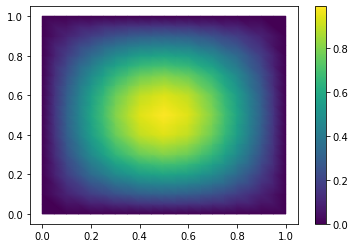

In [8]:
# NBVAL_IGNORE_OUTPUT
fig, axes = plt.subplots()
collection = tripcolor(uh, axes=axes)
fig.colorbar(collection);

# Exercises

Most of the time, we don't want to impose the same Dirichlet condition everywhere.  Instead of solving with homogeneous Dirichlet conditions everywhere, solve the following problem.

Find $u$ such that

$$ -\nabla^2 u = 0 \text{ in } \Omega = [0, 1]\times[0, 1], \\
   u = 1 \text{ on } \Gamma_1, \\
   u = 2 \text{ on } \Gamma_2, \\
   \nabla u \cdot \vec{n} = 0 \text{ on } \Gamma \setminus (\Gamma_1 \cup \Gamma_2),$$
where $\Gamma_1$ is the plane $y = 0$ and $\Gamma_2$ is the plane $y = 1$.

- Hint 1: To provide a zero right hand side, you'll need to write `Constant(0)*v*dx`.
- Hint 2: Use help to remind youself of the boundary markers for meshes.
- Hint 3: The bcs argument to `solve` can be a list of boundary conditions.
- Hint 4: You can check your answer against the exact solution $u^* = 1 + y$.

In [12]:
# set up problem
u = TrialFunction(V)
v = TestFunction(V)
a = dot(grad(u), grad(v))*dx
L = Constant(0)*v*dx

boundary_ids = (1, 2, 3, 4)
bcs_0 = DirichletBC(V, 1, 3)
bcs_1 = DirichletBC(V, 2, 4)

In [13]:
uh = Function(V)
solve(a == L, uh, bcs=[bcs_0, bcs_1], solver_parameters={"ksp_type": "cg", "pc_type": "none"})

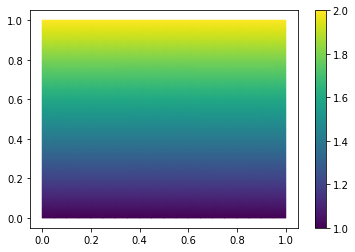

In [14]:
# firedrake solution
fig, axes = plt.subplots()
collection = tripcolor(uh, axes=axes)
fig.colorbar(collection);

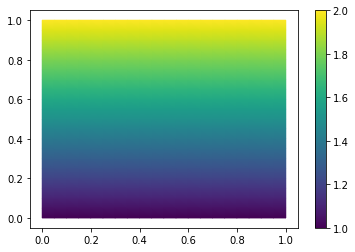

In [19]:
# exact solution
x, y = SpatialCoordinate(mesh)
u_exact = Function(V).interpolate(1 + y)

fig, axes = plt.subplots()
collection = tripcolor(u_exact, axes=axes)
fig.colorbar(collection);

In [11]:
help(UnitSquareMesh)

Help on cython_function_or_method in module firedrake.utility_meshes:

UnitSquareMesh(nx, ny, reorder=None, diagonal='left', quadrilateral=False, distribution_parameters=None, comm=<mpi4py.MPI.Intracomm object at 0x7ff8bea1c2d0>, name='firedrake_default')
    Generate a unit square mesh
    
    :arg nx: The number of cells in the x direction
    :arg ny: The number of cells in the y direction
    :kwarg quadrilateral: (optional), creates quadrilateral mesh, defaults to False
    :kwarg reorder: (optional), should the mesh be reordered
    :kwarg comm: Optional communicator to build the mesh on (defaults to
        COMM_WORLD).
    :kwarg name: Optional name of the mesh.
    
    The boundary edges in this mesh are numbered as follows:
    
    * 1: plane x == 0
    * 2: plane x == 1
    * 3: plane y == 0
    * 4: plane y == 1

